In [3]:
import pandas as pd, numpy as np, re, os
import matplotlib.pyplot as plt, seaborn as sns

# ---- Paths ----
PRED_PATH = "../MentalBert/Output/mentalbert_28labels_predictions.csv"
NRC_PATH  = "../Circumplex Model/NRC-VAD-Lexicon-v2.1/NRC-VAD-Lexicon-v2.1.txt"
OUT_PATH  = "./Output/mentalbert_28labels_with_va.csv"

In [5]:
df = pd.read_csv(PRED_PATH)
print("Columns in CSV:\n", df.columns.tolist()[:15], "...")

# Identify the 28 probability columns
# (exclude obvious non-label columns such as subreddit, text, title, url, etc.)
non_label_cols = ["subreddit", "title", "clean_text", "url", "predicted_emotion", "top3_emotions"]
prob_cols = [c for c in df.columns if c not in non_label_cols]

print(f"✅ Found {len(prob_cols)} emotion-probability columns:")
print(prob_cols)

Columns in CSV:
 ['subreddit', 'title', 'clean_text', 'url', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval'] ...
✅ Found 28 emotion-probability columns:
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [6]:
def load_nrc_vad(path):
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            parts = re.split(r"[\t, ]+", line.strip())
            if len(parts) < 3 or parts[0].lower() in {"word", "token"}:
                continue
            try:
                word = parts[0].lower()
                val = float(parts[1]); aro = float(parts[2])
                rows.append((word, val, aro))
            except ValueError:
                continue
    nrc = pd.DataFrame(rows, columns=["word","valence","arousal"])
    nrc = nrc.groupby("word", as_index=False).mean()
    return nrc

nrc = load_nrc_vad(NRC_PATH)
print(f"NRC entries loaded: {len(nrc)}")

nrc_dict = dict(zip(nrc["word"], zip(nrc["valence"], nrc["arousal"])))

NRC entries loaded: 44726


In [7]:
labels = [re.sub(r"^prob_", "", c) for c in prob_cols]
V = np.full(len(labels), np.nan)
A = np.full(len(labels), np.nan)

for i, lab in enumerate(labels):
    if lab in nrc_dict:
        V[i], A[i] = nrc_dict[lab]

print(f"Mapped {np.isfinite(V).sum()} / {len(labels)} emotions to NRC terms")

# Weighted valence/arousal for each post
P = df[prob_cols].to_numpy(float)
keep = np.isfinite(V)
Pk = P[:, keep]
Vk, Ak = V[keep], A[keep]
wsum = Pk.sum(axis=1, keepdims=True)

valence = (Pk @ Vk) / wsum.ravel()
arousal = (Pk @ Ak) / wsum.ravel()

df["valence"] = valence
df["arousal"] = arousal

Mapped 28 / 28 emotions to NRC terms


In [8]:
# Normalise from [0,1] → [-1,+1]
df["valence_norm"] = df["valence"] * 2 - 1
df["arousal_norm"] = df["arousal"] * 2 - 1

def quadrant(v,a):
    if np.isnan(v) or np.isnan(a): return "NA"
    if v>=0.5 and a>=0.5: return "Q1: Positive–High Arousal"
    if v>=0.5 and a<0.5:  return "Q2: Positive–Low Arousal"
    if v<0.5 and a<0.5:   return "Q3: Negative–Low Arousal"
    return "Q4: Negative–High Arousal"

df["quadrant"] = [quadrant(v,a) for v,a in zip(df["valence"], df["arousal"])]

print(df[["valence","arousal","quadrant"]].head())

    valence   arousal                  quadrant
0 -0.053292 -0.599142  Q3: Negative–Low Arousal
1 -0.655764  0.352825  Q3: Negative–Low Arousal
2 -0.440758  0.185655  Q3: Negative–Low Arousal
3 -0.360715 -0.133575  Q3: Negative–Low Arousal
4 -0.052943 -0.619064  Q3: Negative–Low Arousal


In [9]:
df.to_csv(OUT_PATH, index=False)
print(f"✅ Saved enriched file → {OUT_PATH}")

✅ Saved enriched file → ./Output/mentalbert_28labels_with_va.csv


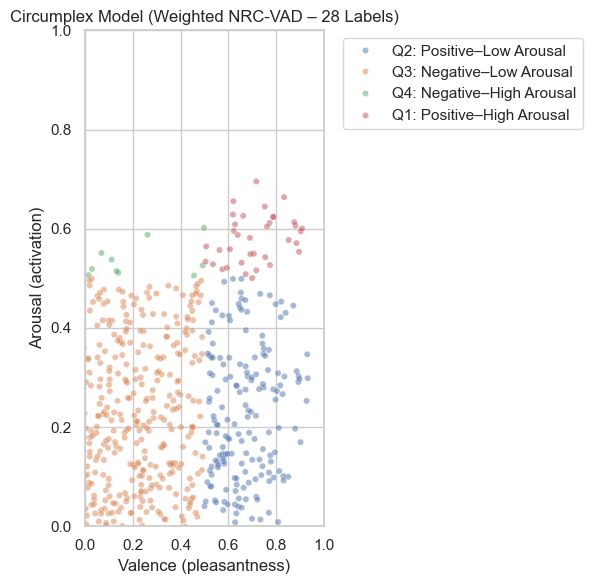

In [10]:
sns.set(style="whitegrid")
sample = df.dropna(subset=["valence","arousal"]).sample(min(5000, len(df)), random_state=42)

plt.figure(figsize=(6,6))
sns.scatterplot(
    x="valence", y="arousal", data=sample,
    hue="quadrant", alpha=0.5, s=20
)
plt.title("Circumplex Model (Weighted NRC-VAD – 28 Labels)")
plt.xlabel("Valence (pleasantness)")
plt.ylabel("Arousal (activation)")
plt.xlim(0,1); plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()